In [1]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt 
import numpy as np 
import firtez_dz as frz
from scipy.interpolate import interpn

In [2]:
atm = frz.read_model("out_valc_nx100_ny100_nz128_dz12_fenacamg.bin")

In [3]:
print("Shape of the atmosphere", atm.tem.shape)
nx, ny, nz = atm.tem.shape

Shape of the atmosphere (100, 100, 128)


In [4]:
# reinterpolate the atmospheres as Ivan to nz_new points in z
x, y, z = (np.arange(d) for d in (nx, ny, nz))
new_nx, new_ny, new_nz = nx, ny, 50
new_x, new_y, new_z = (np.linspace(0, d-1, new_d) for d, new_d in zip((nx, ny, nz), (new_nx, new_ny, new_nz)))
new_xv, new_yv, new_zv = np.meshgrid(new_x, new_y, new_z, indexing='ij', sparse=True)
new_points = (new_xv, new_yv, new_zv)
# tem, pg, vz, bx, by, bz,
atm_new = np.zeros((new_nx, new_ny, new_nz, 6))
atm_new[:,:,:,0] = interpn((x, y, z), atm.tem, new_points)
atm_new[:,:,:,1] = interpn((x, y, z), atm.pg, new_points)
atm_new[:,:,:,2] = interpn((x, y, z), atm.vz, new_points)
atm_new[:,:,:,3] = interpn((x, y, z), atm.bx, new_points)
atm_new[:,:,:,4] = interpn((x, y, z), atm.by, new_points)
atm_new[:,:,:,5] = interpn((x, y, z), atm.bz, new_points)


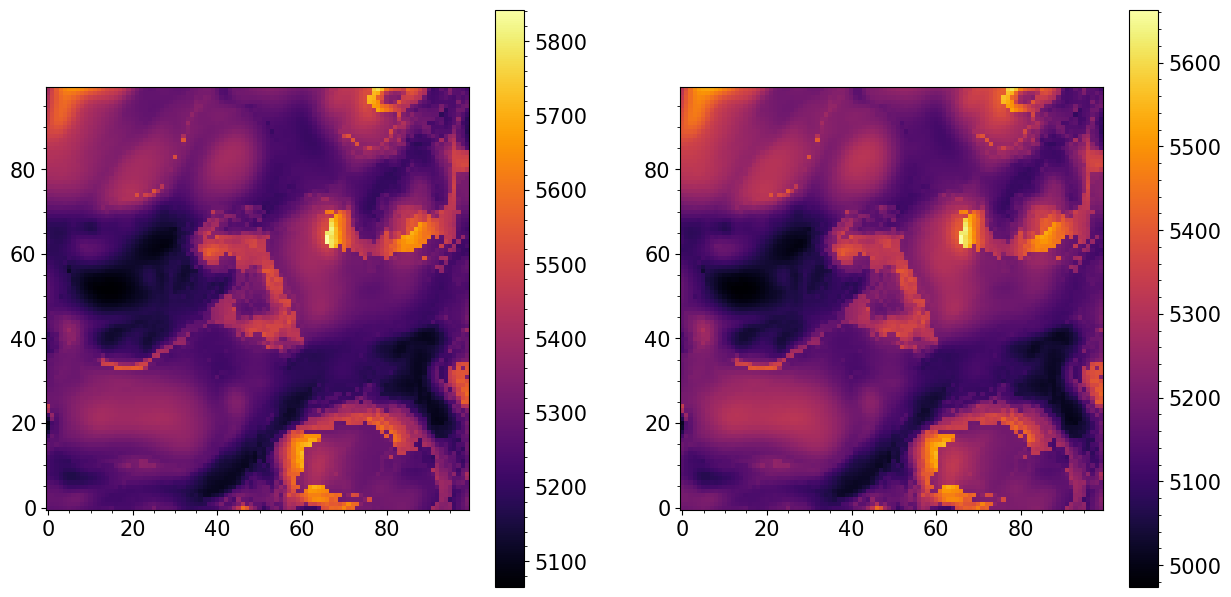

In [5]:
iz0 = 28
izint = int(28*new_nz/nz)

plt.figure(figsize=[15,7.5])
plt.subplot(1,2,1)
plt.imshow(atm_new[:,:,izint,0].T, cmap = 'inferno', origin='lower')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(atm.tem[:,:,iz0].T, cmap = 'inferno', origin='lower')
plt.colorbar()

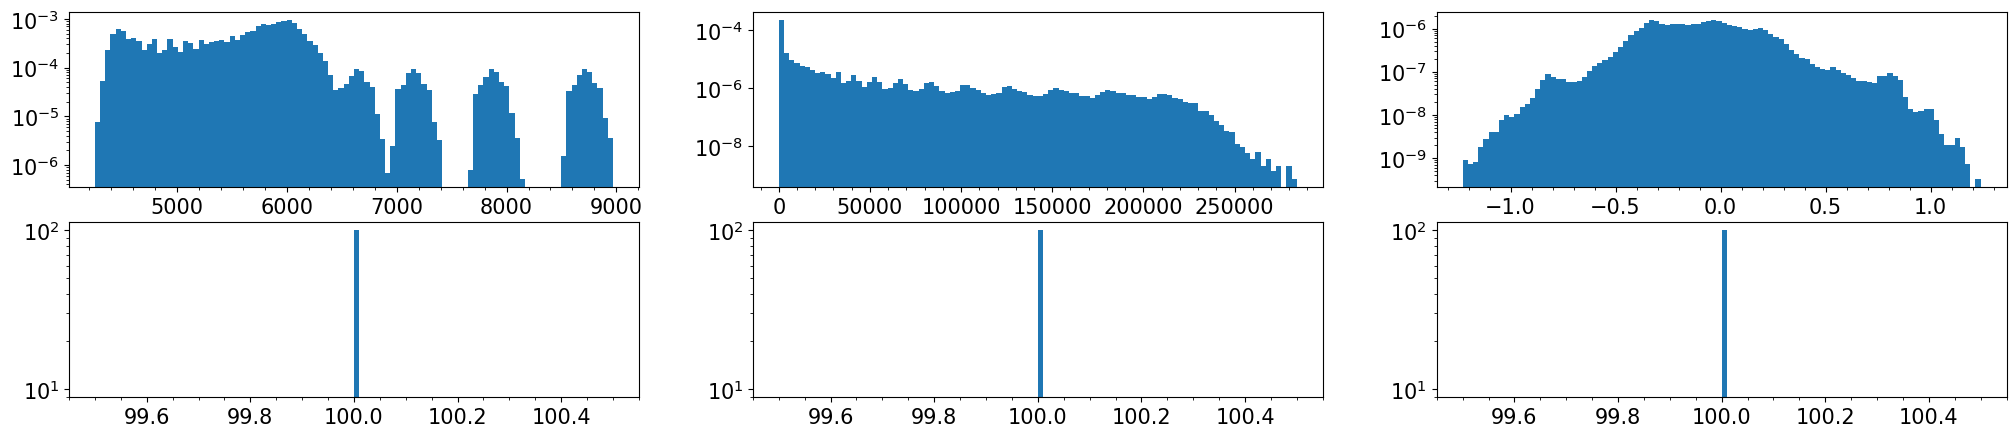

In [6]:
# check the distributions
plt.figure(figsize=[25,5])
for par in range(atm_new.shape[-1]):
    plt.subplot(2,3,par+1)
    plt.hist(atm_new[:,:,:,par].flatten(), bins=100, density=True)
    plt.yscale('log')
plt.show()

In [7]:
# normalize to the mean
atm_new_norm = np.zeros_like(atm_new)
for par in range(atm_new.shape[-1]):
    atm_new_norm[:,:,:,par] = (atm_new[:,:,:,par] - atm_new[:,:,:,par].mean())/atm_new[:,:,:,par].std()
atm_new_norm[:,:,:,-3:] = atm_new[:,:,:,-3:]

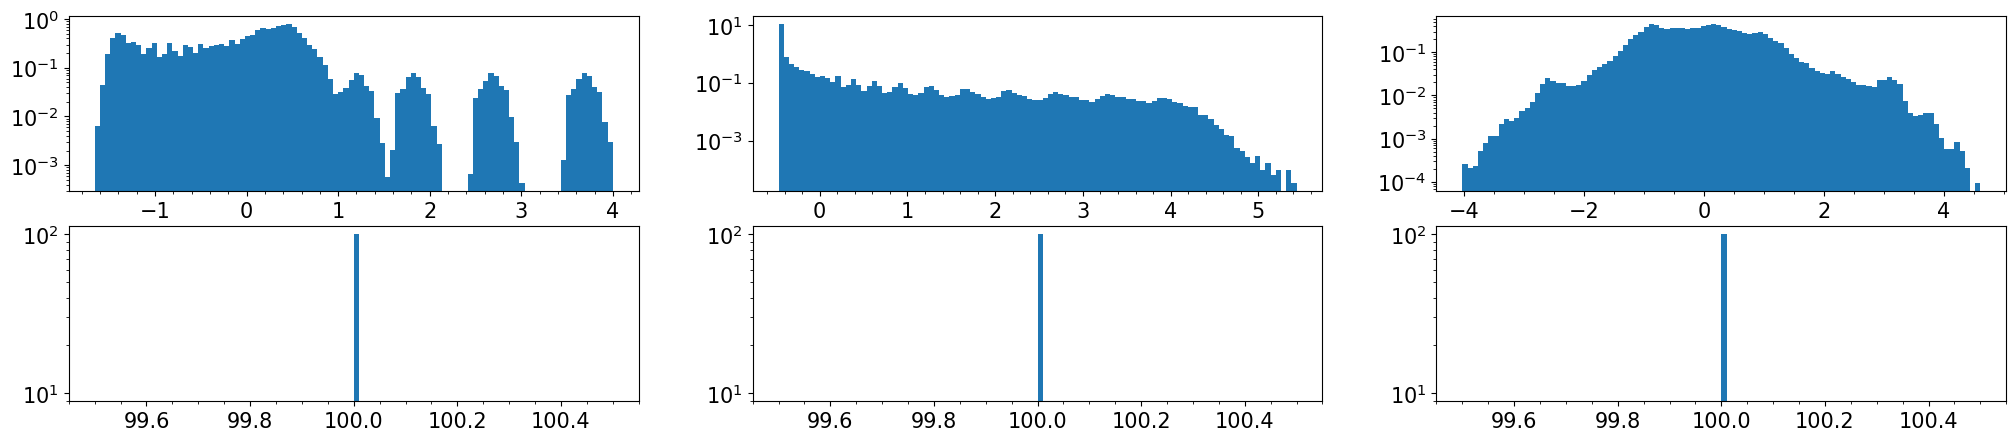

In [8]:
# check the distributions
plt.figure(figsize=[25,5])
for par in range(atm_new.shape[-1]):
    plt.subplot(2,3,par+1)
    plt.hist(atm_new_norm[:,:,:,par].flatten(), bins=100, density=True)
    plt.yscale('log')
plt.show()

Text(0, 0.5, '$x_2$')

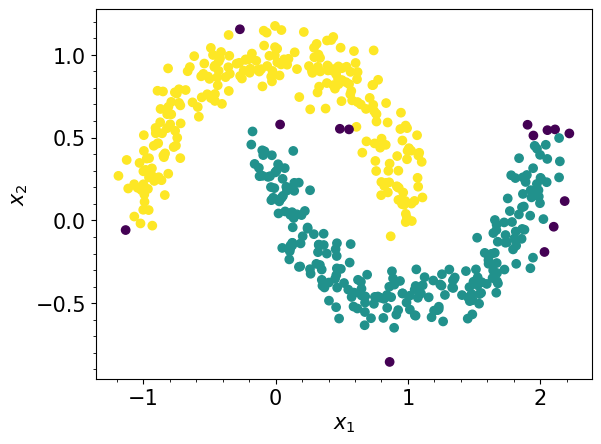

In [9]:
# DBSCAN EXAMPLE
X, y = make_moons(n_samples=500, noise=0.1)

dbscan_cluster = DBSCAN(eps=0.157, min_samples=11)
dbscan_cluster.fit(X)

plt.scatter(X[:, 0], 
X[:, 1], 
c=dbscan_cluster.labels_, 
label=y)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

In [10]:
to_cluster = atm_new_norm[:,:,:,:3]

In [11]:
to_cluster = to_cluster.reshape((-1, new_nz*3))

In [12]:
to_cluster.shape

(10000, 150)

In [17]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import itertools
from tqdm import tqdm

# Define a range of values for eps and min_samples
eps_values = np.arange(4, 5, 0.05)
min_samples_values = range(2000, 5000, 15)

best_score = -1
best_params = {}

for eps, min_samples in tqdm(itertools.product(eps_values, min_samples_values), 'computing the best dbscan', total=len(eps_values)*len(min_samples_values)):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(to_cluster)

    # Check if more than one cluster is found (silhouette_score requires at least 2 labels)
    if len(set(labels)) > 1:
        score = silhouette_score(to_cluster, labels)
        if score > best_score:
            best_score = score
            best_params = {'eps': eps, 'min_samples': min_samples}

print("Best Silhouette Score:", best_score)
print("Best Parameters:", best_params)

# Now, you can run DBSCAN with the best found parameters
if best_params:
    best_dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
    final_labels = best_dbscan.fit_predict(to_cluster)
    # You can then visualize or further analyze these 'final_labels'
else:
    print("No suitable clusters found with the given parameter ranges.")

computing the best dbscan:   0%|          | 12/4000 [00:13<1:15:55,  1.14s/it]


KeyboardInterrupt: 

In [14]:
to_cluster_reshaped = to_cluster.reshape((nx,ny,new_nz, 3))
labels_reshaped = final_labels.reshape((nx,ny))

In [15]:
labels_reshaped.shape

(100, 100)

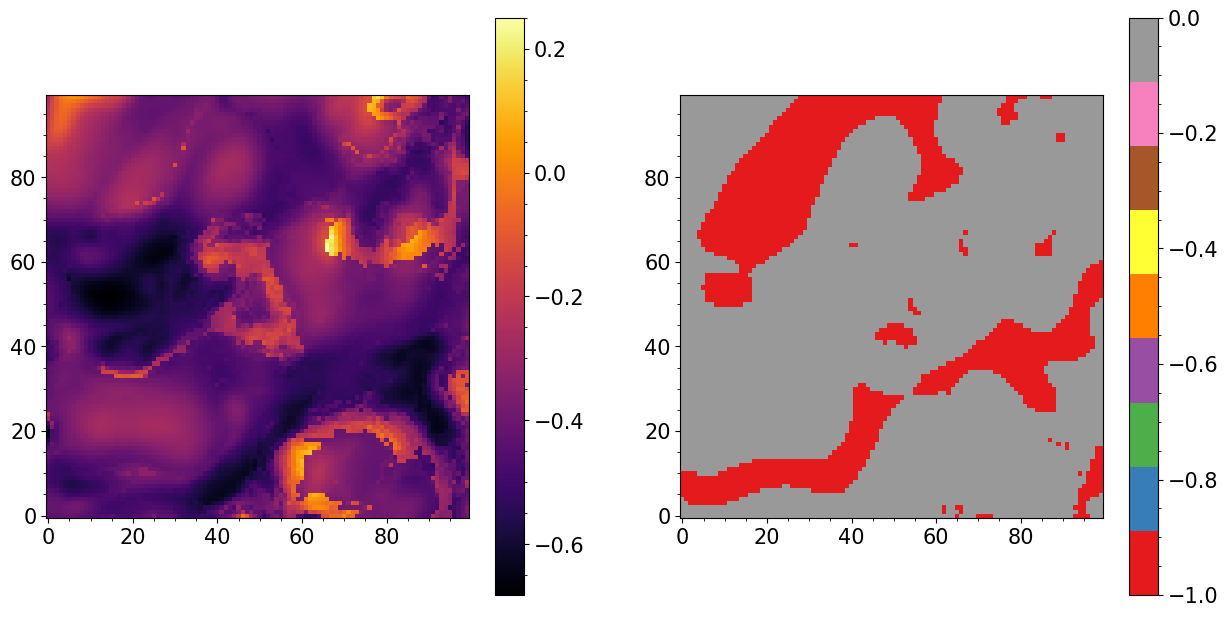

In [16]:
plt.figure(figsize=[15,7.5])
plt.subplot(1,2,1)
plt.imshow(to_cluster_reshaped[:,:,izint,0].T, cmap = 'inferno', origin='lower')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(labels_reshaped.T, cmap='Set1', origin='lower')
plt.colorbar()